<a href="https://colab.research.google.com/github/ssundar6087/Deep-Learning-Mini-Course/blob/main/Pytorch/DL_Minicourse_Pytorch_Day_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Loss function and Optimizer choices
Today, we'll look at the model. Note that 90% of the code will be the same as the previous notebook. Our focus is to play with the model architecture some more and see if we can improve results.

# Image Classification Pytorch

In [ ]:
# Imports
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Model Definition
Replace the definition below with your best conv net from the previous exercise

In [ ]:
class BabyThanos(nn.Module):
  def __init__(self, in_dims, in_channels, n_classes=10):
    super().__init__()
    
    self.in_dims = in_dims 
    self.in_channels = in_channels
    self.n_classes = n_classes
    self.k = 5
    self.n_filters1 = 6
    self.n_filters2 = 16
    self.fc1_dim = 100
    self.fc2_dim = 40
    self.pool_size = 2
    self.pool_stride = 2
    self.final_dim = self.__compute_flattened_dim__(num_conv_pools=2)

    # define the layers here
    self.conv1 = nn.Conv2d(self.in_channels, self.n_filters1, self.k)
    self.pool = nn.MaxPool2d(self.pool_size, self.pool_stride)
    self.conv2 = nn.Conv2d(self.n_filters1, self.n_filters2, self.k)
    self.fc1 = nn.Linear(self.n_filters2 * self.final_dim * self.final_dim, self.fc1_dim)
    self.fc2 = nn.Linear(self.fc1_dim, self.fc2_dim)
    self.fc3 = nn.Linear(self.fc2_dim, self.n_classes)


  def __compute_flattened_dim__(self, num_conv_pools):
    final_dim = self.in_dims
    for i in range(num_conv_pools):
      final_dim = (final_dim + 0 - self.k) // 1 + 1
      final_dim = final_dim // self.pool_size
    return final_dim

  def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x) 
      x = self.pool(x)
      x = self.conv2(x)
      x = F.relu(x) 
      x = self.pool(x)
      x = torch.flatten(x, 1) 
      x = F.relu(self.fc1(x)) 
      x = F.relu(self.fc2(x)) 
      x = self.fc3(x)
      return x
    

In [ ]:
IN_DIMS = 32 
IN_CHANNELS = 3
N_CLASSES = 10
net = BabyThanos(in_dims=IN_DIMS, in_channels=IN_CHANNELS, n_classes=N_CLASSES)

In [ ]:
print(net)

BabyThanos(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=10, bias=True)
)


## Hyperparameters 
**Note:** Use the best values from the previous exercise

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-3

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **YOUR EXERCISE HERE: Define Optimizer & Loss Function 👇** 
These two functions allow us to help baby thanos learn from his mistakes.

Try another optimizer like Adam and see what happens. Does the model get better?

Play around with loss functions in Pytorch as well. Which one gives the best results?

**HINT**: https://neptune.ai/blog/pytorch-loss-functions and https://pytorch.org/docs/stable/optim.html

In [ ]:
criterion = # Loss Function
optimizer = # Optimizer 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Train and Evaluate the Network
The training and validation loops call the same set of functions over and over, so we'll package them into separate functions. Note that the validation loop does not have any optimizer calls. 

In [ ]:
from tqdm.notebook import tqdm
def train_step(model, train_loader, optimizer, criterion):
  model.train()
  epoch_loss = []
  total, correct = 0, 0

  for i, batch in tqdm(enumerate(train_loader), 
                       total=len(train_loader),
                       leave=False,
                       ):
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # Erase history - clean slate

    predictions = model(images) # forward -> model (images) -> make guesses on labels
    loss = criterion(predictions, labels) # how did I do?
    epoch_loss.append(loss.item())
    _, predicted = torch.max(predictions.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item() # Accuracy score
    loss.backward() # backward pass
    optimizer.step() # Update the weights using gradients
  
  return np.mean(epoch_loss), correct / total


In [ ]:
def valid_step(model, val_loader, criterion):
  model.eval()
  epoch_loss = []
  total, correct = 0, 0

  with torch.no_grad():
    for i, batch in tqdm(enumerate(val_loader), 
                        total=len(val_loader),
                        leave=False,
                        ):
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
      # Note that there's no optimizer here
      predictions = model(images)
      loss = criterion(predictions, labels)
      epoch_loss.append(loss.item())
      _, predicted = torch.max(predictions.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  return np.mean(epoch_loss), correct / total

In [ ]:
net = net.to(device)
losses = {"train_loss": [], "val_loss": []}
accuracies = {"train_acc": [], "val_acc": []}
epochs = []
for epoch in tqdm(range(EPOCHS), total=EPOCHS):
  train_loss, train_acc = train_step(net, 
                                     trainloader, 
                                     optimizer, 
                                     criterion,)
  
  val_loss, val_acc = valid_step(net, 
                                 testloader, 
                                 criterion,
                                 )
  
  losses["train_loss"].append(train_loss)
  losses["val_loss"].append(val_loss)
  accuracies["train_acc"].append(train_acc)
  accuracies["val_acc"].append(val_acc)
  epochs.append(epoch)

  print(f'[{epoch + 1}] train loss: {train_loss}  train accuracy: {train_acc}  val loss: {val_loss}  val accuracy: {val_acc}')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[1] train loss: 1.662269997932112  train accuracy: 0.38678  val loss: 1.433758507108992  val accuracy: 0.4872


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[2] train loss: 1.3766201774177649  train accuracy: 0.49834  val loss: 1.2997315218494196  val accuracy: 0.5339


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[3] train loss: 1.253061157053389  train accuracy: 0.54978  val loss: 1.2152475467912711  val accuracy: 0.5652


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[4] train loss: 1.1757659536340963  train accuracy: 0.57904  val loss: 1.1711413621143172  val accuracy: 0.5818


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[5] train loss: 1.118021666241424  train accuracy: 0.60068  val loss: 1.1443436730439496  val accuracy: 0.5999


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[6] train loss: 1.0674000960939072  train accuracy: 0.62216  val loss: 1.123690195524009  val accuracy: 0.6039


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[7] train loss: 1.028123805208889  train accuracy: 0.63608  val loss: 1.120694489615738  val accuracy: 0.6074


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[8] train loss: 0.9849703013896942  train accuracy: 0.65162  val loss: 1.0973190076791557  val accuracy: 0.6176


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[9] train loss: 0.9561977679162379  train accuracy: 0.6627  val loss: 1.0607847506832924  val accuracy: 0.6359


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[10] train loss: 0.9226079180722346  train accuracy: 0.67508  val loss: 1.0369429056811486  val accuracy: 0.645


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[11] train loss: 0.8961445975791463  train accuracy: 0.68438  val loss: 1.0296632947435804  val accuracy: 0.6431


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[12] train loss: 0.8683017337185037  train accuracy: 0.6935  val loss: 1.0632757324322013  val accuracy: 0.6374


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[13] train loss: 0.8493823583244973  train accuracy: 0.70094  val loss: 1.1184240268294219  val accuracy: 0.6254


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[14] train loss: 0.8282227557333534  train accuracy: 0.70674  val loss: 1.0732854031453467  val accuracy: 0.6355


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[15] train loss: 0.806617052811186  train accuracy: 0.71246  val loss: 1.0519884498256027  val accuracy: 0.6469


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[16] train loss: 0.7891172800984834  train accuracy: 0.72062  val loss: 1.033537876074481  val accuracy: 0.6481


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[17] train loss: 0.7705851988414364  train accuracy: 0.72814  val loss: 1.0580583085679705  val accuracy: 0.6537


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[18] train loss: 0.7580308733922442  train accuracy: 0.7318  val loss: 1.0624467514123126  val accuracy: 0.6507


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[19] train loss: 0.7408110649918046  train accuracy: 0.73828  val loss: 1.0483847154173882  val accuracy: 0.6499


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[20] train loss: 0.7262039524133858  train accuracy: 0.74198  val loss: 1.0715660775543019  val accuracy: 0.6571


## Plot the Loss and Accuracy of our Model

Text(0.5, 1.0, 'Loss vs Epochs')

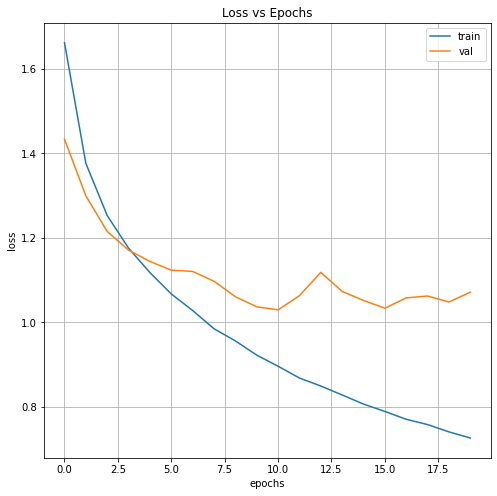

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(epochs, losses["train_loss"], label="train")
plt.plot(epochs, losses["val_loss"], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.title("Loss vs Epochs")

Text(0.5, 1.0, 'Accuracy vs Epochs')

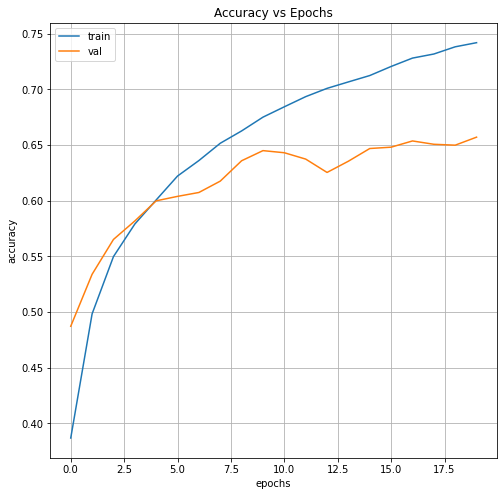

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(epochs, accuracies["train_acc"], label="train")
plt.plot(epochs, accuracies["val_acc"], label="val")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.title("Accuracy vs Epochs")